<a href="https://colab.research.google.com/github/UmairBinAhmad/MSDS19036_COVID19_DLSpring2020/blob/master/covid19_classification_focal_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import itertools
import sklearn 
import csv

In [0]:
data_dir = '/content/drive/My Drive/A_05_Part_02_Dataset'

In [0]:
train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [4]:
#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform=valid_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
validloader = torch.utils.data.DataLoader(validation_data, batch_size=16, shuffle = True, num_workers=4)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [0]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True, num_workers=4)

In [0]:
class ImageFolderWithPaths(datasets.ImageFolder):
  def __getitem__(self, index):
    original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
    path = self.imgs[index][0]
    tuple_with_path = (original_tuple + (path,))
    return tuple_with_path

In [0]:
test_data = ImageFolderWithPaths(data_dir+'/Test', transform=test_transforms) 
testloader = torch.utils.data.DataLoader(test_data)

In [7]:
print(len(train_data))
print(len(validation_data))
print(len(test_data))

6200
628
629


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


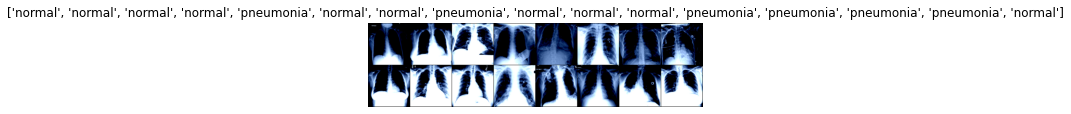

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(validloader))
show_databatch(inputs, classes)

#### ***Metrics and Accuracy Functions***

In [0]:
def metrics(true_labels,predicted_labels):
  pre=[]
  for x in predicted_labels:
    for y in x:
      pre.append(y.cpu().numpy())
  act=[]
  for x in true_labels:
    for y in x:
      act.append(y.cpu().numpy())

  act = np.asarray(act)
  pre = np.asarray(pre)

  recall = recall_score(y_true = act, y_pred= pre, average='weighted')
  precision = precision_score(y_true = act, y_pred= pre, average='weighted')
  F1_Score = f1_score(y_true = act, y_pred= pre, average='weighted')
  conf_matrix = multilabel_confusion_matrix(act,pre)
  return recall, precision, F1_Score, conf_matrix 

In [0]:
def Sigmoid(X):
  Sigm = nn.Sigmoid()
  s = Sigm(X)
  return s

In [0]:
def ClassWise_Accuracy(network, dataset, class_labels):
  inx = 0 
  class_correct = list(0. for i in range(len(class_labels)))
  class_total = list(0. for i in range(len(class_labels)))
  covid_class = torch.FloatTensor([1., 0., 1.]).cuda()
  normal_class = torch.FloatTensor([0., 1., 0.]).cuda()
  pneumonia_class = torch.FloatTensor([0., 0., 1.]).cuda()
  with torch.no_grad():
    for data in dataset:
        images, labels = data
        lbls = one_hot_encode(labels)
        images, lbls = images.to(device), lbls.to(device)
        outputs = network(images)
        predicted = Sigmoid(outputs)
        predicted[predicted > 0.5] = 1
        predicted[predicted <= 0.5] = 0
        for j in range(0,lbls.size(0)):
          if (predicted[j] == covid_class).sum()==3 and (predicted[j]==lbls[j]).sum()==3:
            class_correct[0]+=1
          if (predicted[j] == normal_class).sum()==3 and (predicted[j]==lbls[j]).sum()==3:
            class_correct[1]+=1
          if (predicted[j] == pneumonia_class).sum()==3 and (predicted[j]==lbls[j]).sum()==3:
            class_correct[2]+=1
          if (lbls[j] == covid_class).sum()==3: class_total[0]+=1
          if (lbls[j] == normal_class).sum()==3: class_total[1]+=1
          if (lbls[j] == pneumonia_class).sum()==3: class_total[2]+=1
        inx += 1
        print("\r: ",inx,end="")
  print("\n")
  for i in range(len(class_labels)):
    print('Accuracy of %5s : %2d %%' % (class_labels[i], 100 * class_correct[i] / class_total[i]))
    print(class_labels[i],': ',class_correct[i],'/',class_total[i])

In [0]:
def ModelAccuracy(network, dataset):

  correct = total = inx = 0 
  predlist=[]
  lbllist=[]

  with torch.no_grad():
    for data in dataset:

        images, labels = data
        lbls = one_hot_encode(labels)
        images, lbls = images.to(device), lbls.to(device)
        outputs = network(images)
        predicted = Sigm(outputs)
        predicted[predicted > 0.5] = 1
        predicted[predicted <= 0.5] = 0
        
        predlist.append(predicted)
        lbllist.append(lbls)

        c_count = 0
        for j in range(0,lbls.size(0)):
          if(predicted[j]==lbls[j]).sum()==3:
            c_count+=1
            correct+=1

        inx += 1
        print("\rIterating on image batches : ",inx,end="")
        total += labels.size(0)
        
  return (100*correct/total), predlist, lbllist

In [0]:
def one_hot_encode(X):
  OneHot = []
  for label in X:
    if label == 0:
      OneHot.append([1., 0., 1.])
    if label == 1:
      OneHot.append([0., 1., 0.])
    if label == 2:
      OneHot.append([0., 0., 1.])

  return torch.FloatTensor(OneHot)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### **Fine Tuning on VGG 16**
*BCEWithLogitsLoss*

In [0]:
# Load the pretrained model
vgg16 = models.vgg16(pretrained=False)

In [17]:
num_features = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[:-7] # Remove last layer
print(features)
print(num_features)

features.extend(
    [nn.Linear(num_features, 4096 ),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5,inplace=False),

     nn.Linear(4096 , 900 ),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5,inplace=False),

     nn.Linear(900 ,len(class_names))])

vgg16.classifier = nn.Sequential(*features)
print(vgg16)

[]
25088
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [0]:
# load pretrained model
vgg16.load_state_dict(torch.load('/content/drive/My Drive/covid19_weights_2/vgg16_BCE.pth'))
vgg16.cuda()

In [0]:
# Loss fucntion and optimizer
Epochs = 30
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
Sigm = nn.Sigmoid() # Sigmoid 
n = len(train_data)

loss_v = []
acc_v = []
correct = 0

for epoch in range(Epochs):  

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        
        inputs, labels = data
        
        lbls = one_hot_encode(labels)
        inputs, lbls = inputs.to(device), lbls.to(device)
        optimizer.zero_grad()
        
        outputs = vgg16(inputs)             #----> forward pass
        loss = criterion(outputs, lbls)     #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      
        running_loss += loss.item()

        predicted = Sigm(outputs)
        predicted[predicted > 0.5] = 1
        predicted[predicted <= 0.5] = 0
        
        c_count = 0
        for j in range(0,lbls.size(0)):
          if(predicted[j]==lbls[j]).sum()==3:
            c_count+=1
            correct+=1

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))

    acc_v.append(100 * correct / n) 
    loss_v.append(running_loss/len(trainloader))
    correct = 0
    
    torch.save(vgg16.state_dict(), '/content/drive/My Drive/covid19_weights_2/vgg16_BCE.pth')

print('Finished Training')



0it [00:00, ?it/s]

Train Epoch: 0 [0/6200 (0%)]	Loss: 0.000112: : 0it [00:08, ?it/s]

Train Epoch: 0 [0/6200 (0%)]	Loss: 0.000112: : 1it [00:08,  8.13s/it]

Train Epoch: 0 [64/6200 (1%)]	Loss: 0.000120: : 1it [00:08,  8.13s/it]

Train Epoch: 0 [64/6200 (1%)]	Loss: 0.000120: : 2it [00:08,  5.85s/it]

Train Epoch: 0 [128/6200 (2%)]	Loss: 0.000148: : 2it [00:09,  5.85s/it]

Train Epoch: 0 [128/6200 (2%)]	Loss: 0.000148: : 3it [00:09,  4.26s/it]

Train Epoch: 0 [192/6200 (3%)]	Loss: 0.000256: : 3it [00:09,  4.26s/it]

Train Epoch: 0 [192/6200 (3%)]	Loss: 0.000256: : 4it [00:09,  3.14s/it]

Train Epoch: 0 [256/6200 (4%)]	Loss: 0.000099: : 4it [00:10,  3.14s/it]

Train Epoch: 0 [256/6200 (4%)]	Loss: 0.000099: : 5it [00:10,  2.36s/it]

Train Epoch: 0 [320/6200 (5%)]	Loss: 0.000770: : 5it [00:10,  2.36s/it]

Train Epoch: 0 [320/6200 (5%)]	Loss: 0.000770: : 6it [00:10,  1.81s/it]

Train Epoch: 0 [384/6200 (6%)]	Loss: 0.000200: : 6it [00:11,  1.81s/it]

Train Epoch: 0 [384/6200 (6%)]	Loss: 0.

Finished Training


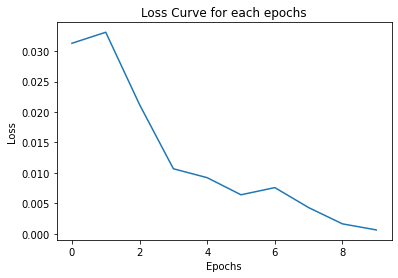

In [0]:
plt.title("Loss Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_v)

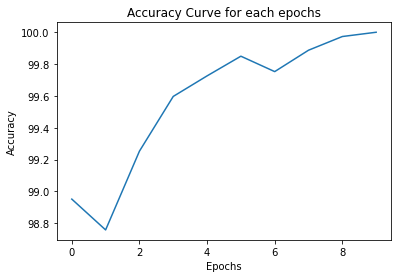

In [0]:
plt.title("Accuracy Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(acc_v)

**Training Accuracy**

In [133]:
acc, pre, lbl = ModelAccuracy(vgg16,trainloader)
print("\nAccuracy on Training Data %d%%" % acc)

Iterating on image batches :  97
Accuracy on Training Data 100%


In [0]:
ClassWise_Accuracy(vgg16,trainloader,class_names)

:  40

In [62]:
recall , precision , f1, conf_mat = metrics(pre,lbl)

print("Covid19\n",conf_mat[0])
print("Normal\n",conf_mat[1])
print("Pneumonia\n",conf_mat[2])

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Covid19
 [[6000    0]
 [   0  200]]
Normal
 [[2200    0]
 [   0 4000]]
Pneumonia
 [[4000    0]
 [   0 2200]]
Precision:  1.0
Recall:  1.0
F1 Score:  1.0


**Validation Accuracy**

In [63]:
acc, pre,lbl = ModelAccuracy(vgg16, validloader)
print("\nAccuracy on Validation Data: %d%%" % acc)

Iterating on image batches :  40
Accuracy on Validation Data: 94%


In [135]:
ClassWise_Accuracy(vgg16,validloader,class_names)

:  40

Accuracy of covid-19 : 67 %
covid-19 :  19.0 / 28.0
Accuracy of normal : 96 %
normal :  386.0 / 400.0
Accuracy of pneumonia : 94 %
pneumonia :  188.0 / 200.0


In [64]:
recall , precision , f1, conf_mat = metrics(pre,lbl)
print("Covid19\n",conf_mat[0])
print("Normal\n",conf_mat[1])
print("Pneumonia\n",conf_mat[2])

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Covid19
 [[599   6]
 [  1  22]]
Normal
 [[212  10]
 [ 16 390]]
Pneumonia
 [[388  18]
 [ 12 210]]
Precision:  0.9499156878371042
Recall:  0.9554531490015361
F1 Score:  0.9522985607701283


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  pneumonia covid-19
Predicted :  0 pneumonia
Predicted :  1 pneumonia


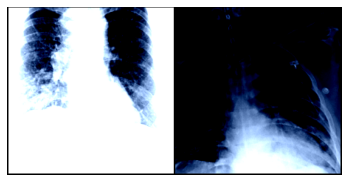

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images,labels = images[:2],labels[:2]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) 
for j in range(len(images)):
  outputs = vgg16(images) 
  pr = Sigmoid(outputs)
  #print(pr[0])
  pr[pr > 0.5] = 1
  pr[pr <= 0.5] = 0
  m = np.where(pr[0].cpu() == 1)[0]
  print('Predicted : ',j, ') '.join(class_names[i] for i in m))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  pneumonia
tensor([3.2153e-10, 5.8207e-19, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward>)
Predicted :  pneumonia


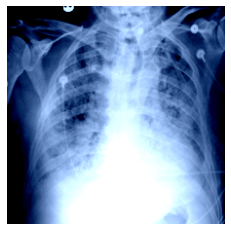

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
images,labels = images[:1],labels[:1]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) 
outputs = vgg16(images) 
pr = Sigmoid(outputs)
print(pr[0])
pr[pr > 0.5] = 1
pr[pr <= 0.5] = 0
m = np.where(pr[0].cpu() == 1)[0]
print('Predicted : ', ' '.join(class_names[i] for i in m))

### **Fine Tuning on Resnet**
*BCEWithLogitsLoss*

In [65]:
resnet18 = models.resnet18(pretrained= False)  #load model class
nfeatures = resnet18.fc.in_features
features = list(resnet18.fc.children())[:-1] #FC Layer
print(features)

[]


In [0]:
# adding new FC layers
features.extend(
    [nn.Linear(nfeatures, 500 ),
     nn.ReLU(inplace=True),
     nn.Linear(500 ,3)])

resnet18.fc = nn.Sequential(*features)
print(resnet18)

In [0]:
# load pretrained model
resnet18.load_state_dict(torch.load('/content/drive/My Drive/covid19_weights_2/resnet18_BCE_n1.pth'))
resnet18.cuda()

In [0]:
# Loss fucntion and optimizer
Epochs = 20
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
resnet18.train()

Sigm = nn.Sigmoid() # Sigmoid 
n = len(train_data) # length of training data

loss_r = []
acc_r = []
correct = 0

for epoch in range(Epochs):  

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        
        inputs, labels = data
        lbls = one_hot_encode(labels)  # convert labels into onehot vector
        inputs, lbls = inputs.to(device), lbls.to(device)
        #labels = labels.to(device)
        optimizer.zero_grad()
        
        outputs = resnet18(inputs)          #----> forward pass
        loss = criterion(outputs, lbls)     #----> compute BCE loss (built in sigmoid)
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        running_loss += loss.item()

        predicted = Sigm(outputs)
        predicted[predicted > 0.5] = 1
        predicted[predicted <= 0.5] = 0

        #correct += (predicted == lbls).sum().item()
        c_count = 0
        for j in range(0,lbls.size(0)):
          if(predicted[j]==lbls[j]).sum()==3:
            c_count+=1
            correct+=1

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))

    acc_r.append(100 * correct / n) 
    loss_r.append(running_loss/len(trainloader))
    correct = 0
    
    torch.save(resnet18.state_dict(), '/content/drive/My Drive/covid19_weights_2/resnet18_BCE.pth')

print('Finished Training')

Train Epoch: 0 [4632/6200 (99%)]	Loss: 0.186167: : 194it [01:39,  1.94it/s]
Train Epoch: 1 [4632/6200 (99%)]	Loss: 0.212230: : 194it [01:41,  1.91it/s]
Train Epoch: 2 [4632/6200 (99%)]	Loss: 0.137664: : 194it [01:39,  1.96it/s]
Train Epoch: 3 [4632/6200 (99%)]	Loss: 0.179982: : 194it [01:38,  1.97it/s]
Train Epoch: 4 [4632/6200 (99%)]	Loss: 0.077598: : 194it [01:37,  1.99it/s]
Train Epoch: 5 [4632/6200 (99%)]	Loss: 0.086894: : 194it [01:36,  2.01it/s]
Train Epoch: 6 [4632/6200 (99%)]	Loss: 0.010953: : 194it [01:36,  2.00it/s]
Train Epoch: 7 [4632/6200 (99%)]	Loss: 0.026386: : 194it [01:36,  2.00it/s]
Train Epoch: 8 [4632/6200 (99%)]	Loss: 0.144259: : 194it [01:36,  2.01it/s]
Train Epoch: 9 [4632/6200 (99%)]	Loss: 0.018257: : 194it [01:37,  1.99it/s]
Train Epoch: 10 [4632/6200 (99%)]	Loss: 0.018652: : 194it [01:37,  2.00it/s]
Train Epoch: 11 [4632/6200 (99%)]	Loss: 0.004152: : 194it [01:37,  2.00it/s]
Train Epoch: 12 [4632/6200 (99%)]	Loss: 0.003937: : 194it [01:37,  2.00it/s]
Train Epo

Finished Training


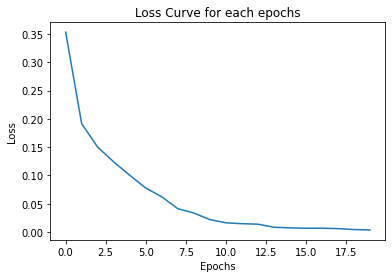

In [0]:
plt.title("Loss Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_r)

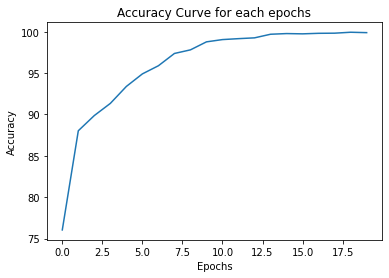

In [0]:
plt.title("Accuracy Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(acc_r)

**Training Accuracy**

In [69]:
acc, pr, lb = ModelAccuracy(resnet18,trainloader)
print("\nAccuracy on Training Data %d%%" % acc)

Iterating on image batches :  97
Accuracy on Training Data 100%


In [140]:
ClassWise_Accuracy(resnet18,trainloader,class_names)

:  97

Accuracy of covid-19 : 100 %
covid-19 :  200.0 / 200.0
Accuracy of normal : 100 %
normal :  4000.0 / 4000.0
Accuracy of pneumonia : 100 %
pneumonia :  2000.0 / 2000.0


In [70]:
recall , precision , f1, conf_mat = metrics(pr,lb)

print("Covid19\n",conf_mat[0])
print("Normal\n",conf_mat[1])
print("Pneumonia\n",conf_mat[2])

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Covid19
 [[6000    0]
 [   0  200]]
Normal
 [[2200    0]
 [   0 4000]]
Pneumonia
 [[4000    0]
 [   0 2200]]
Precision:  1.0
Recall:  1.0
F1 Score:  1.0


**Validation Accuracy**

In [71]:
acc, pre, lbl = ModelAccuracy(resnet18,validloader)
print("\nAccuracy on Validation Data %d%%" % acc)

Iterating on image batches :  40
Accuracy on Validation Data 92%


In [141]:
ClassWise_Accuracy(resnet18,validloader,class_names)

:  40

Accuracy of covid-19 : 67 %
covid-19 :  19.0 / 28.0
Accuracy of normal : 95 %
normal :  380.0 / 400.0
Accuracy of pneumonia : 88 %
pneumonia :  176.0 / 200.0


In [74]:
recall , precision , f1, conf_mat = metrics(pre,lbl)

print("Covid19\n",conf_mat[0])
print("Normal\n",conf_mat[1])
print("Pneumonia\n",conf_mat[2])
print("-----------------------------")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Covid19
 [[600  10]
 [  0  18]]
Normal
 [[200  13]
 [ 28 387]]
Pneumonia
 [[385  27]
 [ 15 201]]
-----------------------------
Precision:  0.9298998169537865
Recall:  0.9337442218798151
F1 Score:  0.9303192965728964


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  normal
tensor([2.2189e-05, 9.7846e-01, 2.1555e-02], device='cuda:0',
       grad_fn=<SelectBackward>)
Predicted :  normal


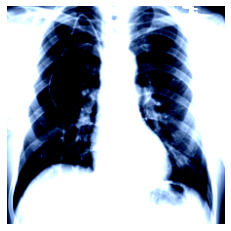

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images,labels = images[:1],labels[:1]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) 
outputs = resnet18(images) 
pr = Sigmoid(outputs)
print(pr[0])
pr[pr > 0.5] = 1
m = np.where(pr[0].cpu() == 1)[0]
print('Predicted : ', ' '.join(class_names[i] for i in m)) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  normal
tensor([1.8680e-05, 9.8030e-01, 1.9818e-02], device='cuda:0',
       grad_fn=<SelectBackward>)
Predicted :  normal


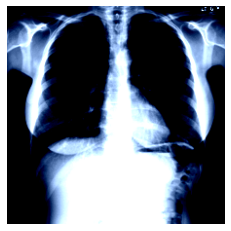

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
images,labels = images[:1],labels[:1]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) 
outputs = resnet18(images) 
pr = Sigmoid(outputs)
print(pr[0])
pr[pr > 0.5] = 1
pr[pr <= 0.5] = 0
m = np.where(pr[0].cpu() == 1)[0]
print('Predicted : ', ' '.join(class_names[i] for i in m)) 

## Focal Loss

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, reduce=False):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
      BCEL = nn.BCEWithLogitsLoss()
      BCE_loss = BCEL(inputs, targets)
      pt = torch.exp(-BCE_loss)
      F_loss = (1-pt)**self.gamma * BCE_loss
      if self.reduce:
          return torch.mean(F_loss)
      else:
          return F_loss

### **Focal loss (VGG-16)**

In [0]:
# load model class 
VGG = models.vgg16(pretrained=False)
# remove FC layers
num_features = VGG.classifier[0].in_features
features = list(VGG.classifier.children())[:-7] # Remove last layer
print(features)
print(num_features)
# add new FC layer
features.extend(
    [nn.Linear(num_features, 4096 ),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5,inplace=False),
     nn.Linear(4096 , 900 ),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5,inplace=False),
     nn.Linear(900 ,len(class_names))])
VGG.classifier = nn.Sequential(*features)
print(VGG)

In [0]:
# load pretrained model
VGG.load_state_dict(torch.load('/content/drive/My Drive/covid19_weights_2/vgg16_focal_loss_n3.pth'))
VGG.cuda()

In [0]:
FL = FocalLoss(gamma=2.5)

In [0]:
# Loss fucntion and optimizer
Epochs = 40
optimizer = optim.SGD(VGG.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
VGG.to(device)

VGG.train()
Sigm = nn.Sigmoid() # Sigmoid 
n = len(train_data)

loss_v = []
acc_v = []
correct = 0

for epoch in range(Epochs):  

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        
        inputs, labels = data
        lbls = one_hot_encode(labels)
        inputs, lbls = inputs.to(device), lbls.to(device)

        optimizer.zero_grad()
        
        outputs = VGG(inputs)               #----> forward pass
        loss = FL.forward(outputs,lbls)     #----> focal compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      
        running_loss += loss.item()

        predicted = Sigm(outputs)
        predicted[predicted > 0.5] = 1
        predicted[predicted <= 0.5] = 0

        c_count = 0
        for j in range(0,lbls.size(0)):
          if(predicted[j]==lbls[j]).sum()==3:
            c_count+=1
            correct+=1

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))

    acc_v.append(100 * correct / n) 
    loss_v.append(running_loss/len(trainloader))
    correct = 0
    
    torch.save(VGG.state_dict(), '/content/drive/My Drive/covid19_weights_2/vgg16_focal_loss.pth')

print('Finished Training')


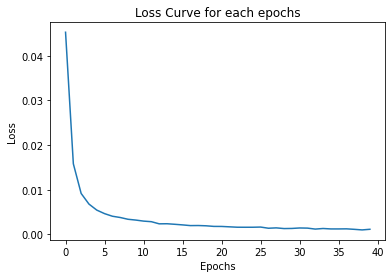

In [0]:
plt.title("Loss Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_v)

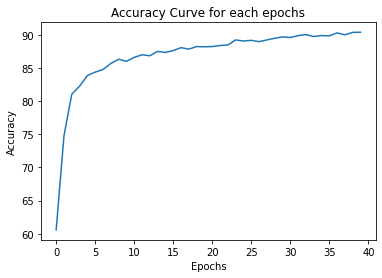

In [0]:
plt.title("Accuracy Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(acc_v)

#### Accuracy Scores (VGG-16 Focal Loss)

**Training Accuracy**

In [151]:
acc, pre, lbl = ModelAccuracy(VGG,trainloader)
print("\nAccuracy on Training Data %d%%" % acc)

Iterating on image batches :  97
Accuracy on Training Data 93%


In [153]:
ClassWise_Accuracy(VGG,trainloader,class_names)

:  97

Accuracy of covid-19 : 53 %
covid-19 :  106.0 / 200.0
Accuracy of normal : 95 %
normal :  3823.0 / 4000.0
Accuracy of pneumonia : 88 %
pneumonia :  1779.0 / 2000.0


In [80]:
recall , precision , f1, conf_mat = metrics(pre,lbl)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("----------------------")
print("Covid19\n",conf_mat[0])
print("Normal\n",conf_mat[1])
print("Pneumonia\n",conf_mat[2])

Precision:  0.9307339542255569
Recall:  0.9376199616122841
F1 Score:  0.9320633077790905
----------------------
Covid19
 [[5997  138]
 [   3   62]]
Normal
 [[1949  134]
 [ 251 3866]]
Pneumonia
 [[3864  266]
 [ 136 1934]]


**Validation Accuracy**

In [149]:
acc, pr, lb = ModelAccuracy(VGG,validloader)
print("\nAccuracy on Validation Data %d%%" % acc)

Iterating on image batches :  40
Accuracy on Validation Data 91%


In [154]:
ClassWise_Accuracy(VGG,validloader,class_names)

:  40

Accuracy of covid-19 : 25 %
covid-19 :  7.0 / 28.0
Accuracy of normal : 94 %
normal :  376.0 / 400.0
Accuracy of pneumonia : 89 %
pneumonia :  179.0 / 200.0


In [150]:
recall , precision , f1, conf_mat = metrics(pr,lb)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("----------------------")
print("Covid19\n",conf_mat[0])
print("Normal\n",conf_mat[1])
print("Pneumonia\n",conf_mat[2])

Precision:  0.9287082191459958
Recall:  0.9314641744548287
F1 Score:  0.9273772614690089
----------------------
Covid19
 [[599  18]
 [  1  10]]
Normal
 [[198  12]
 [ 30 388]]
Pneumonia
 [[387  28]
 [ 13 200]]


In [83]:
count = 0
for i in pr:
  for f in i:
    if f[0] == 1 and f[1] == 0 and f[2]==1:
      count+=1
print(count)

64


### **Focal loss (Resnet-18)**

In [0]:
class FLoss(nn.Module):
    def __init__(self,alpha=1,gamma=2):
        super(FLoss,self).__init__()
        self.alpha=alpha
        self.gamma=gamma
    def forward(self,inputs,targets):
        loss=F.binary_cross_entropy_with_logits(inputs,targets,reduce=False)
        pt=torch.exp(-loss)
        FL=self.alpha*(1-pt)**self.gamma*loss
        
        return torch.mean(FL)

In [0]:
RESNET = models.resnet18(pretrained= True)  #load model class
nfeatures = RESNET.fc.in_features
features = list(RESNET.fc.children())[:-1] #FC Layer
print(features)

# adding new FC layers
features.extend(
    [nn.Linear(nfeatures, 500 ),
     nn.ReLU(inplace=True),
     nn.Linear(500 ,3)])

RESNET.fc = nn.Sequential(*features)
print(RESNET)

In [0]:
# load pretrained model
RESNET.load_state_dict(torch.load('/content/drive/My Drive/covid19_weights_2/resnet18_focal_loss.pth'))
RESNET.cuda()

In [0]:
# Loss fucntion and optimizer
Epochs = 20
#FL = FocalLoss(gamma=2)
FL = FLoss(alpha = 0.25, gamma = 2)
optimizer = optim.SGD(RESNET.parameters(), lr=0.001, momentum=0.9)

In [221]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RESNET.to(device)
RESNET.train()

Sigm = nn.Sigmoid() # Sigmoid 
n = len(train_data) # length of training data

#loss_r = []
#acc_r = []
correct = 0

for epoch in range(Epochs):  

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        
        inputs, labels = data
        lbls = one_hot_encode(labels)  # convert labels into onehot vector
        inputs, lbls = inputs.to(device), lbls.to(device)
        optimizer.zero_grad()
        
        outputs = RESNET(inputs)           #----> forward pass
        loss = FL(outputs,lbls)    #----> compute Focal loss
        loss.backward()                    #----> backward pass
        optimizer.step()                   #----> weights update
        running_loss += loss.item()
        predicted = Sigm(outputs)
        predicted[predicted > 0.5] = 1
        predicted[predicted <= 0.5] = 0

        c_count = 0
        for j in range(0,lbls.size(0)):
          if(predicted[j]==lbls[j]).sum()==3:
            c_count+=1
            correct+=1

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))

    acc_r.append(100 * correct / n) 
    loss_r.append(running_loss/len(trainloader))
    correct = 0
    
    torch.save(RESNET.state_dict(), '/content/drive/My Drive/covid19_weights_2/resnet18_focal_loss_new1.pth')

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Train Epoch: 7 [1280/6200 (21%)]	Loss: 0.003893: : 20it [00:30,  1.15it/s]

Train Epoch: 7 [1280/6200 (21%)]	Loss: 0.003893: : 21it [00:30,  1.48it/s]

Train Epoch: 7 [1344/6200 (22%)]	Loss: 0.002189: : 21it [00:30,  1.48it/s]

Train Epoch: 7 [1344/6200 (22%)]	Loss: 0.002189: : 22it [00:30,  1.81it/s]

Train Epoch: 7 [1408/6200 (23%)]	Loss: 0.006667: : 22it [00:37,  1.81it/s]

Train Epoch: 7 [1408/6200 (23%)]	Loss: 0.006667: : 23it [00:37,  2.47s/it]

Train Epoch: 7 [1472/6200 (24%)]	Loss: 0.002819: : 23it [00:37,  2.47s/it]

Train Epoch: 7 [1472/6200 (24%)]	Loss: 0.002819: : 24it [00:37,  1.80s/it]

Train Epoch: 7 [1536/6200 (25%)]	Loss: 0.002777: : 24it [00:38,  1.80s/it]

Train Epoch: 7 [1536/6200 (25%)]	Loss: 0.002777: : 25it [00:38,  1.33s/it]

Train Epoch: 7 [1600/6200 (26%)]	Loss: 0.003161: : 25it [00:39,  1.33s/it]

Train Epoch: 7 [1600/6200 (26%)]	Loss: 0.003161: : 26it [00:39,  1.19s/it]

Train Epoch: 7 [1664/6200 (27%)]	Loss

Finished Training


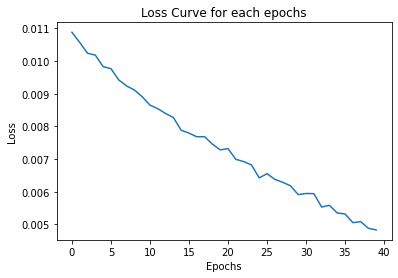

In [156]:
plt.title("Loss Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_r)

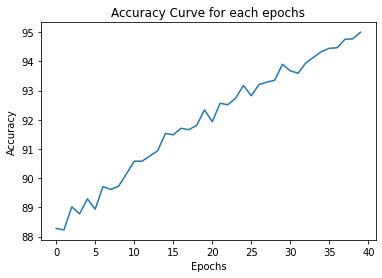

In [157]:
plt.title("Accuracy Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(acc_r)

#### Accuracy Scores (Resnet18-Focal Loss)

**Training Accuracy**

In [222]:
acc, pre, lbl = ModelAccuracy(RESNET,trainloader)
print("\nAccuracy on Training Data %d%%" % acc)

Iterating on image batches :  97
Accuracy on Training Data 97%


In [224]:
ClassWise_Accuracy(RESNET,trainloader,class_names)

:  97

Accuracy of covid-19 : 68 %
covid-19 :  136.0 / 200.0
Accuracy of normal : 99 %
normal :  3973.0 / 4000.0
Accuracy of pneumonia : 96 %
pneumonia :  1927.0 / 2000.0


In [225]:
recall , precision , f1, conf_mat = metrics(pre,lbl)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("----------------------")
print("Covid19\n",conf_mat[0])
print("Normal\n",conf_mat[1])
print("Pneumonia\n",conf_mat[2])

Precision:  0.9780623797213844
Recall:  0.9859399684044233
F1 Score:  0.9813943068387099
----------------------
Covid19
 [[5997   64]
 [   3  136]]
Normal
 [[2147   34]
 [  53 3966]]
Pneumonia
 [[3967   61]
 [  33 2139]]


**Validation Accuracy**

In [226]:
acc, pr, lb = ModelAccuracy(RESNET,validloader)
print("\nAccuracy on Validation Data %d%%" % acc)

Iterating on image batches :  40
Accuracy on Validation Data 89%


In [227]:
ClassWise_Accuracy(RESNET,validloader,class_names)

:  40

Accuracy of covid-19 : 32 %
covid-19 :  9.0 / 28.0
Accuracy of normal : 93 %
normal :  373.0 / 400.0
Accuracy of pneumonia : 86 %
pneumonia :  173.0 / 200.0


In [228]:
recall , precision , f1, conf_mat = metrics(pr,lb)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("----------------------")
print("Covid19\n",conf_mat[0])
print("Normal\n",conf_mat[1])
print("Pneumonia\n",conf_mat[2])

Precision:  0.9112943834349281
Recall:  0.916403785488959
F1 Score:  0.9116456156083692
----------------------
Covid19
 [[599  23]
 [  1   5]]
Normal
 [[197  22]
 [ 31 378]]
Pneumonia
 [[379  30]
 [ 21 198]]


## Write Data in CSV

In [15]:
#f = open('MSDS19036_Results.csv', 'w')
#writer = csv.writer(f)
predlist=[]

for inputs, label, path in testloader:
  inputs = inputs.to(device)
  outputs = resnet18(images)
  predicted = Sigmoid(outputs)
  predicted[predicted > 0.5] = 1
  predicted[predicted <= 0.5] = 0

  predlist.append(predicted)
  #input_row = []
  #input_row.append(str(list(path)[0]).split('/')[-1])
  #input_row.append(int(predicted[0][0].cpu().numpy()))
  #input_row.append(int(predicted[0][2].cpu().numpy()))
  #input_row.append(int(predicted[0][1].cpu().numpy()))
  #writer.writerow(input_row)
  #print(input_row)
#f.close()

NameError: ignored

In [284]:
count = 0
for i in predlist:
  for f in i:
    if f[0] == 0 and f[1] == 0 and f[2]==1:
      count+=1
print(count)

2516


## Testing 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground Truth: covid-19
Predicted :  covid-19 pneumonia


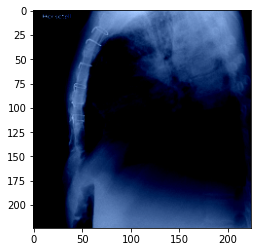

In [196]:
inputs, classes = next(iter(trainloader))
idx = 53
img = inputs[idx].cpu().numpy().transpose((1, 2, 0))
plt.imshow(img)
print("Ground Truth:", class_names[classes[idx].numpy()])
images, labels = inputs.to(device), classes.to(device) 
outputs = vgg16(images) 
pr = Sigmoid(outputs)
pr[pr > 0.5] = 1
pr[pr <= 0.5] = 0
m = np.where(pr[idx].cpu() == 1)[0]
print('Predicted : ', ' '.join(class_names[i] for i in m)) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Groudn Truth: normal
Predicted :  normal


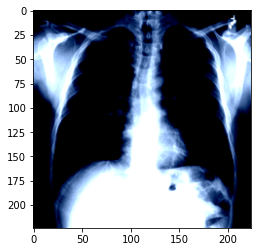

In [208]:
inputs, classes = next(iter(validloader))
idx = 14
img = inputs[idx].cpu().numpy().transpose((1, 2, 0))
plt.imshow(img)
print("Groudn Truth:", class_names[classes[idx].numpy()])
images, labels = inputs.to(device), classes.to(device) 
outputs = resnet18(images) 
pr = Sigmoid(outputs)
pr[pr > 0.5] = 1
pr[pr <= 0.5] = 0
m = np.where(pr[idx].cpu() == 1)[0]
print('Predicted : ', ' '.join(class_names[i] for i in m)) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Groudn Truth: pneumonia
Predicted :  pneumonia


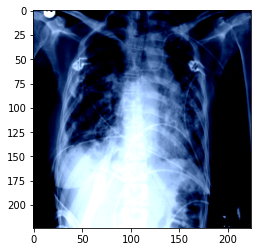

In [220]:
#inputs, classes = next(iter(validloader))
idx = 2
img = inputs[idx].cpu().numpy().transpose((1, 2, 0))
plt.imshow(img)
print("Groudn Truth:", class_names[classes[idx].numpy()])
images, labels = inputs.to(device), classes.to(device) 
outputs = RESNET(images) 
pr = Sigmoid(outputs)
pr[pr > 0.5] = 1
pr[pr <= 0.5] = 0
m = np.where(pr[idx].cpu() == 1)[0]
print('Predicted : ', ' '.join(class_names[i] for i in m)) 